In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2_wheeler_related/modified_latest1_finalday31.csv', parse_dates=['loggingTime(txt)'])
df['loggingTime(txt)'] = df['loggingTime(txt)'].dt.tz_localize(None)
df.set_index('loggingTime(txt)', inplace=True)
print(df.index[:5])
data = df[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)','gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)','motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']]

DatetimeIndex(['2023-10-12 00:07:51.978000', '2023-10-12 00:07:52.077000',
               '2023-10-12 00:07:52.177000', '2023-10-12 00:07:52.281000',
               '2023-10-12 00:07:52.377000'],
              dtype='datetime64[ns]', name='loggingTime(txt)', freq=None)


In [ ]:
len(data)

11639

In [ ]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        window_data = df_as_np[i:i + window_size]
        X.append(window_data)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE =  9
X1, y1 = df_to_X_y(data, WINDOW_SIZE)
X1.shape, y1.shape

((11630, 9, 9), (11630, 9))

In [ ]:
print(f'Given the Array: \n{X1[0].flatten()}')
print(f'Predict this y: \n {y1[0]}')

Given the Array: 
[ 0.07354736 -0.75434875 -0.68067932 -0.09562586 -0.06986963 -0.20864536
 -2.12188381  0.23257235  0.6722108   0.09832764 -0.68560791 -0.71806335
 -0.09562586 -0.06986963 -0.20864536 -2.15065502  0.23633575  0.67014412
  0.09352112 -0.72615051 -0.67736816  0.01891803 -0.48011574 -0.25613776
 -2.17754352  0.22667693  0.65901752  0.06822205 -0.6852417  -0.73815918
 -0.17105004 -0.39643043 -0.23170461 -2.21708371  0.20937873  0.6753173
  0.05445862 -0.6905365  -0.7906189   0.0357524  -0.68974596 -0.08532874
 -2.24848104  0.19150961  0.66217588 -0.01676941 -0.74804688 -0.75968933
  0.41279876 -0.2067641  -0.38248587 -2.26717518  0.16031343  0.66103389
  0.06143188 -0.75376892 -0.60308838  0.07987273 -0.94649172 -0.76152265
 -2.29947458  0.12704884  0.68848353 -0.02716064 -0.65640259 -0.56268311
 -0.25095871  0.18435226 -0.3051759  -2.38206484  0.13471041  0.70484969
  0.04600525 -0.62124634 -0.57498169  0.1693632   0.94645071  0.53919291
 -2.45026618  0.13501185  0.701335

In [ ]:
# Split the data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
total_samples = len(X1)
train_samples = int(0.7 * total_samples)
val_samples = int(0.15 * total_samples)
test_samples = total_samples - train_samples - val_samples

# Split the data into train, validation, and test sets
X_train, y_train = X1[:train_samples], y1[:train_samples]
X_val, y_val = X1[train_samples:train_samples + val_samples], y1[train_samples:train_samples + val_samples]
X_test, y_test = X1[train_samples + val_samples:], y1[train_samples + val_samples:]

# # Reshape X_train before normalization
# # Reshape and normalize X_train
# scaler_X = MinMaxScaler()
# samples, window_size, features = X_train.shape
# X_train_reshaped = X_train.reshape(samples, -1)  # Reshape to (number_of_samples, WINDOW_SIZE * 9)
# X_train_normalized = scaler_X.fit_transform(X_train_reshaped).reshape(samples, window_size, features)  # Reshape back to (number_of_samples, WINDOW_SIZE, 9)

# # # Similarly, reshape and normalize X_val and X_test
# X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
# X_val_normalized = scaler_X.transform(X_val_reshaped).reshape(X_val.shape[0], window_size, features)

# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
# X_test_normalized = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], window_size, features)



# # # Normalize output labels
# scaler_y = MinMaxScaler()
# y_train_normalized = scaler_y.fit_transform(y_train)
# y_val_normalized = scaler_y.transform(y_val)
# y_test_normalized = scaler_y.transform(y_test)



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit

# GRU Architecture
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 9),))
model1.add(GRU(64, input_shape=(WINDOW_SIZE, 9), return_sequences=True))
model1.add(GRU(units=32, return_sequences=True))
model1.add(GRU(units=16))
model1.add(Dense(9, activation='relu'))
model1.add(Dense(9, activation='LeakyReLU'))
model1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), run_eagerly=True)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 9, 64)             14400     
                                                                 
 gru_4 (GRU)                 (None, 9, 32)             9408      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 9)                 153       
                                                                 
 dense_3 (Dense)             (None, 9)                 90        
                                                                 
Total params: 26451 (103.32 KB)
Trainable params: 26451 (103.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the number of splits for time series cross-validation
n_splits = 4  # You can adjust this based on your preference
tscv = TimeSeriesSplit(n_splits=n_splits)
mae_scores = []

In [ ]:
for train_index, test_index in tscv.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

X_train shape: (2326, 9, 9)
y_train shape: (2326, 9)
X_train shape: (4652, 9, 9)
y_train shape: (4652, 9)
X_train shape: (6978, 9, 9)
y_train shape: (6978, 9)
X_train shape: (9304, 9, 9)
y_train shape: (9304, 9)


In [ ]:
model1.fit(X_train, y_train, epochs=50)  # Set verbose to 1 for debugging


Epoch 1/50
291/291 [==============================] - 66s 226ms/step - loss: 0.2238
Epoch 2/50
291/291 [==============================] - 68s 234ms/step - loss: 0.1181
Epoch 3/50
291/291 [==============================] - 67s 230ms/step - loss: 0.1012
Epoch 4/50
291/291 [==============================] - 68s 232ms/step - loss: 0.0987
Epoch 5/50
291/291 [==============================] - 68s 233ms/step - loss: 0.0972
Epoch 6/50
291/291 [==============================] - 67s 229ms/step - loss: 0.0961
Epoch 7/50
291/291 [==============================] - 68s 234ms/step - loss: 0.0944
Epoch 8/50
291/291 [==============================] - 67s 230ms/step - loss: 0.0931
Epoch 9/50
291/291 [==============================] - 68s 235ms/step - loss: 0.0922
Epoch 10/50
291/291 [==============================] - 67s 231ms/step - loss: 0.0914
Epoch 11/50
291/291 [==============================] - 68s 234ms/step - loss: 0.0910
Epoch 12/50
291/291 [==============================] - 67s 229ms/step - lo

In [ ]:
y_pred = model1.predict(X_test)

73/73 [==============================] - 7s 92ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mae_scores.append(mae)

In [ ]:
mean_mae = np.mean(mae_scores)
print(f"Mean Cross-Validated MAE: {mean_mae}")


Mean Cross-Validated MAE: 0.1124020367860794


In [ ]:
y_train.shape

(9304, 9)

In [ ]:
train_predictions = model1.predict(X_train).flatten()
y_train = y_train.flatten()

train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})
print(train_results)

train_predictions = model1.predict(X_train)
train_predictions.shape

num_outputs = train_predictions.shape[1]

# Define output labels
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': train_predictions.flatten()[:150], 'Actual': y_train.flatten()[:150]})
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['RMSE'] = np.sqrt(np.square(output_data['Residual']))


    mse = (output_data['Residual'] ** 2).mean()
    rmse = np.sqrt(mse)
    print(output_labels[i],rmse)
    # Plot predicted and actual values
    # plt.figure(figsize=(8, 4))
    # plt.plot(output_data['Predicted'], label='Predicted')
    # plt.plot(output_data['Actual'], label='Actual')
    # plt.xlabel('Sample Index')
    # plt.ylabel('Value')
    # plt.title(f'{output_labels[i]} Predicted vs Actual')
    # plt.legend()
    # plt.show()

291/291 [==============================] - 27s 92ms/step
       Train Predictions   Actuals
0              -0.011201  0.083679
1              -0.231593 -0.598770
2              -0.754878 -0.651184
3              -0.373025 -0.622097
4              -0.215516 -0.166788
...                  ...       ...
83731          -0.007695  0.264293
83732          -0.025790 -0.091685
83733           1.490979  1.514535
83734          -0.185166 -0.201302
83735          -0.177322 -0.177395

[83736 rows x 2 columns]
291/291 [==============================] - 27s 92ms/step
accelerometerAccelerationX(G) 0.35986149231988795
accelerometerAccelerationY(G) 0.35986149231988795
accelerometerAccelerationZ(G) 0.35986149231988795
gyroRotationX(rad/s) 0.35986149231988795
gyroRotationY(rad/s) 0.35986149231988795
gyroRotationZ(rad/s) 0.35986149231988795
motionYaw(rad) 0.35986149231988795
motionRoll(rad) 0.35986149231988795
motionPitch(rad) 0.35986149231988795


55/55 [==============================] - 5s 85ms/step


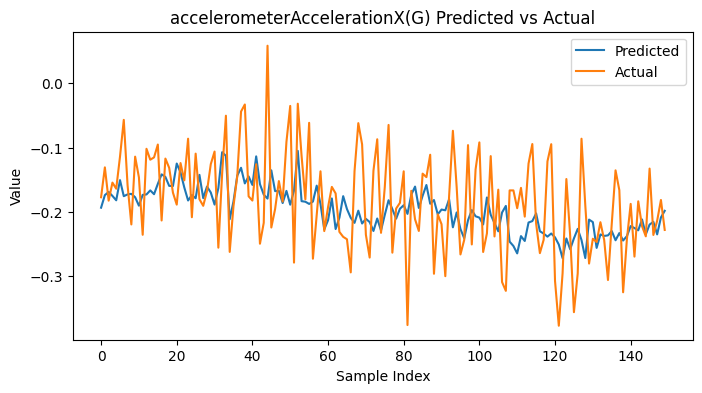

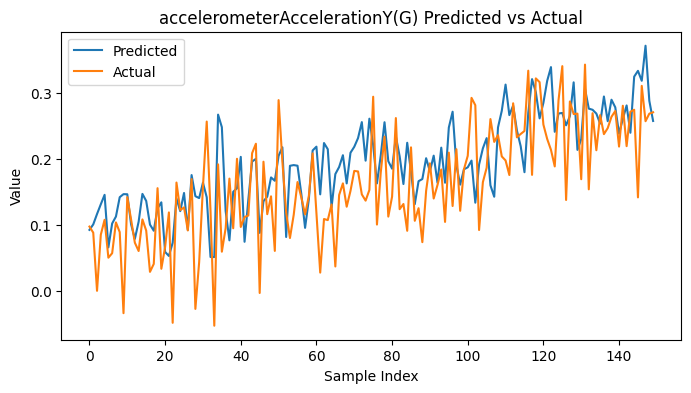

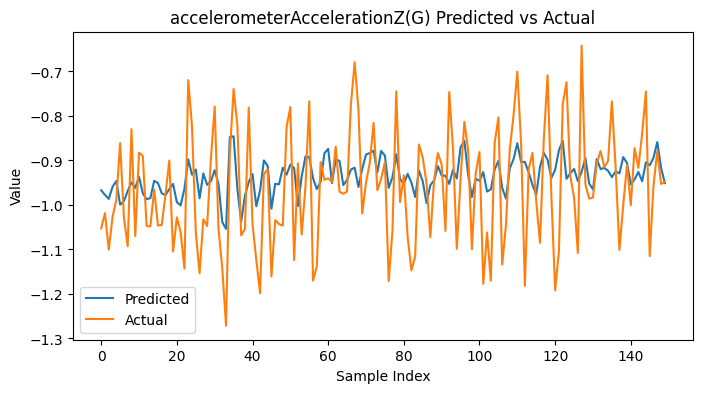

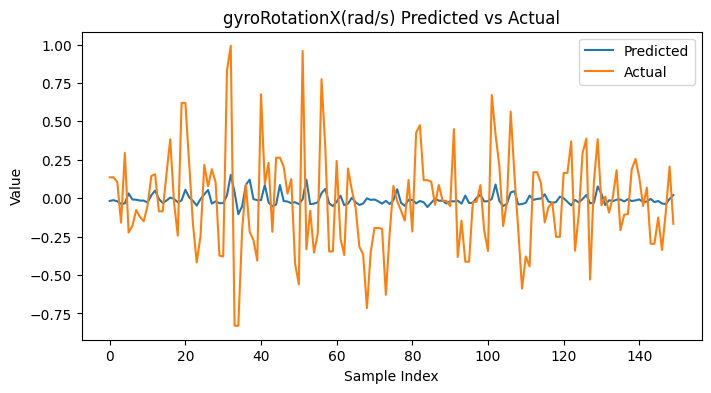

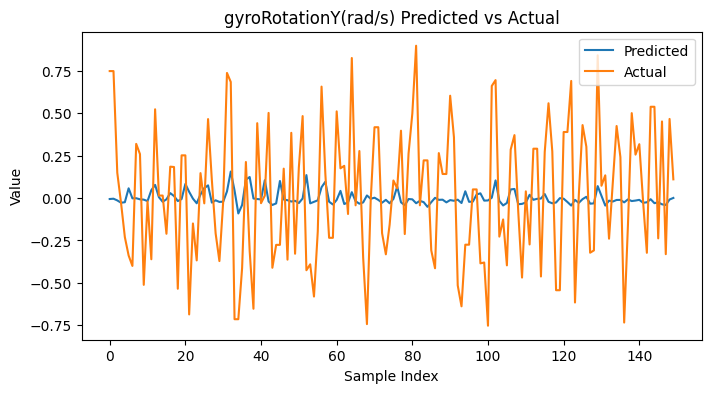

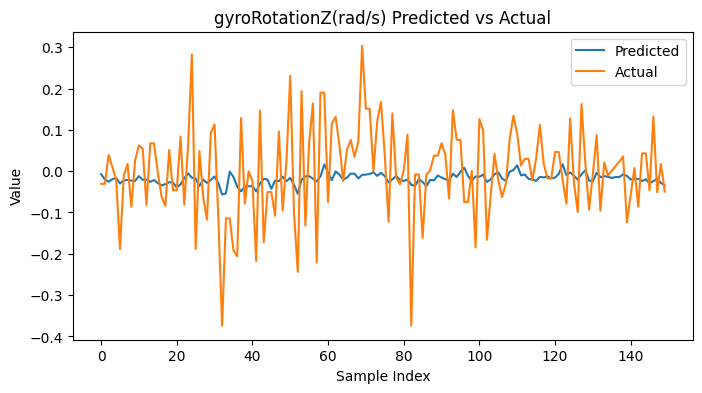

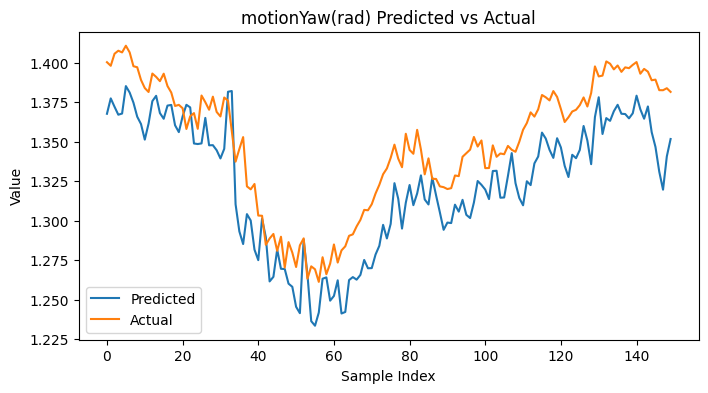

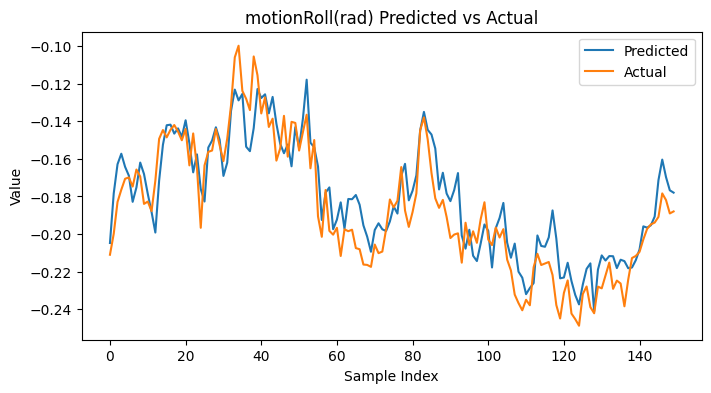

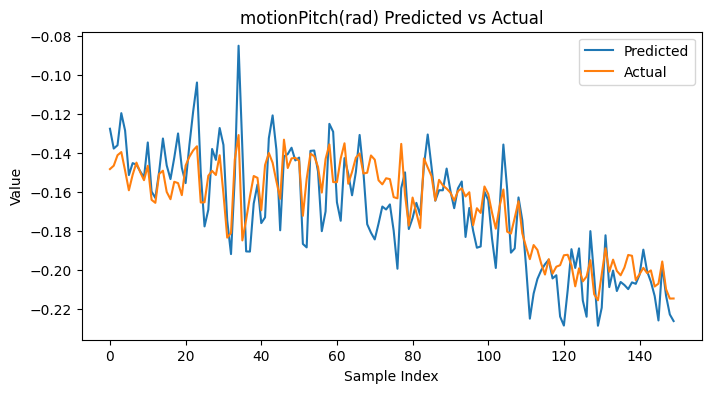

In [ ]:

val_predictions = model1.predict(X_val)
val_predictions.shape

num_outputs = val_predictions.shape[1]

# Define output labels
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': val_predictions[:, i][:150], 'Actual': y_val[:, i][:150]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'], label='Predicted')
    plt.plot(output_data['Actual'], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()

73/73 [==============================] - 7s 98ms/step


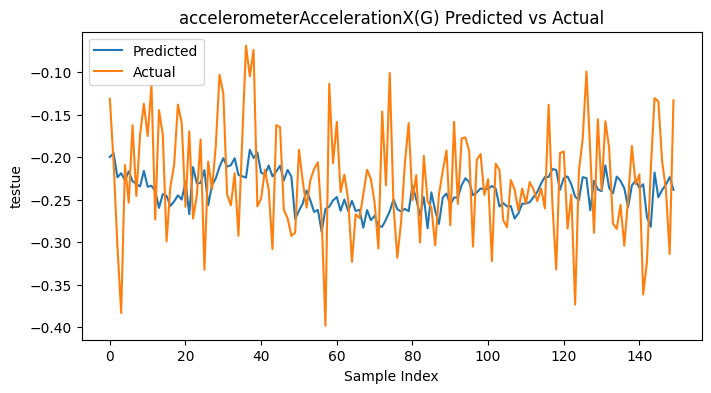

RMSE for accelerometerAccelerationX(G): 0.051513883670171075


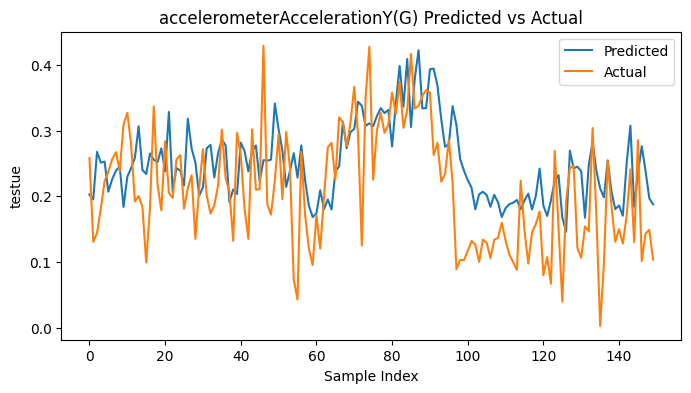

RMSE for accelerometerAccelerationY(G): 0.06747705668210977


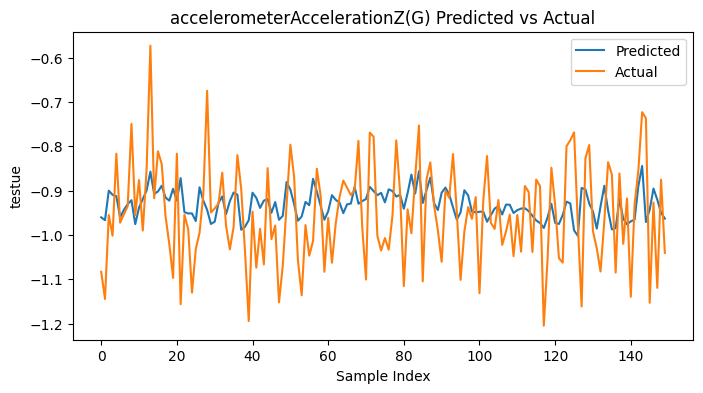

RMSE for accelerometerAccelerationZ(G): 0.08796683748563164


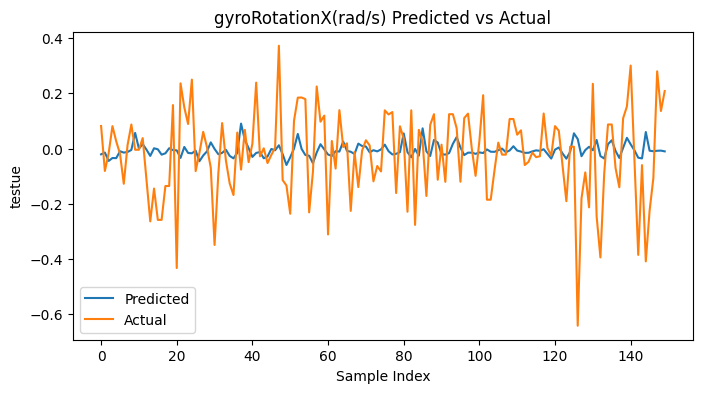

RMSE for gyroRotationX(rad/s): 0.11904158129754554


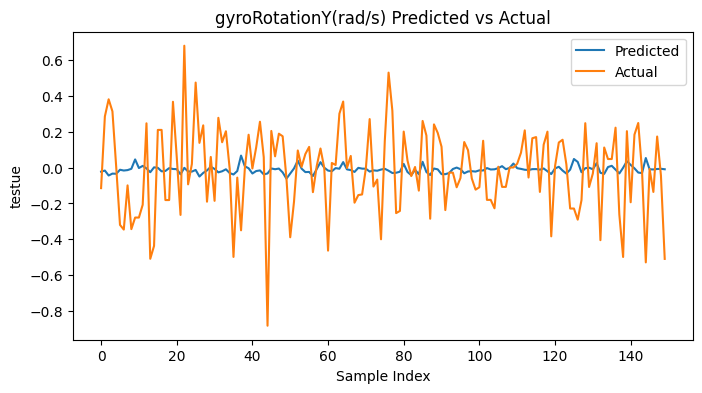

RMSE for gyroRotationY(rad/s): 0.18352743980435965


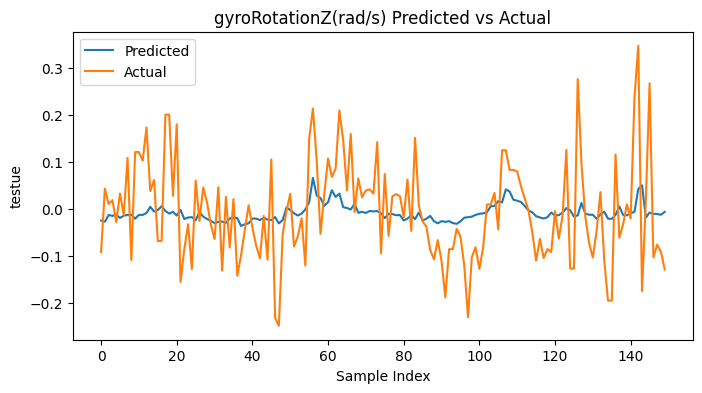

RMSE for gyroRotationZ(rad/s): 0.0787909700688518


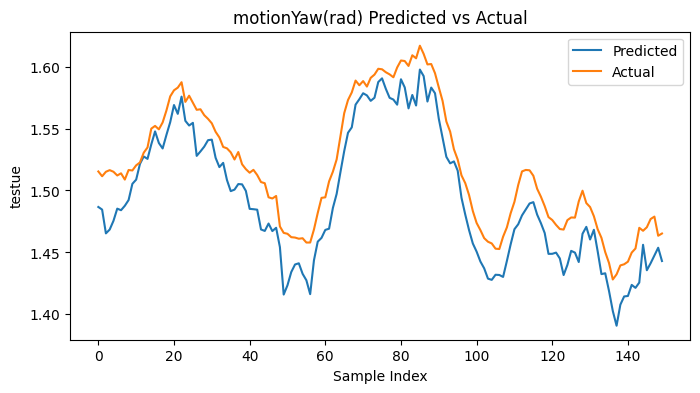

RMSE for motionYaw(rad): 0.024538279306110945


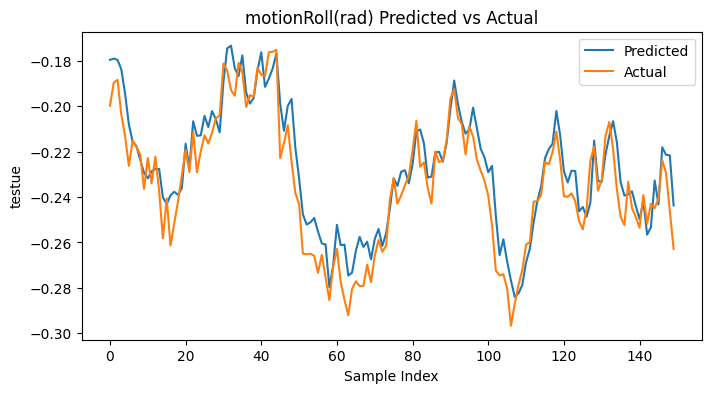

RMSE for motionRoll(rad): 0.009107626862556029


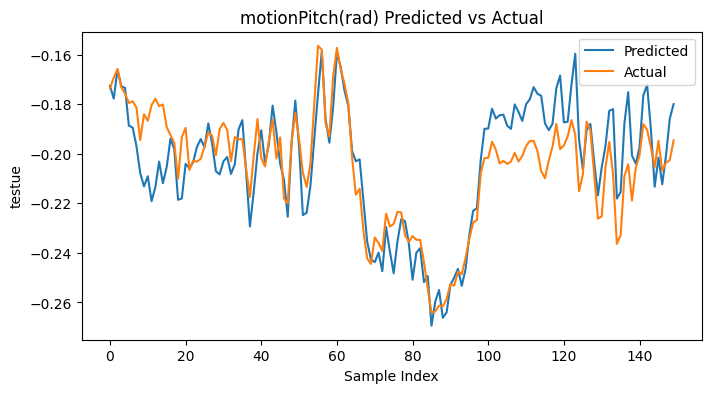

RMSE for motionPitch(rad): 0.01047641290371717


In [ ]:
test_predictions = model1.predict(X_test)
test_predictions.shape

num_outputs = test_predictions.shape[1]

# Define output labels
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual testues for the current output
    output_data = pd.DataFrame(data={'Predicted': test_predictions[:, i][:150], 'Actual': y_test[:, i][:150]})

    # Plot predicted and actual testues
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'], label='Predicted')
    plt.plot(output_data['Actual'], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('testue')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()
      # Calculate and print RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['Squared Residual'] = np.square(output_data['Residual'])
    output_data['RMSE'] = np.sqrt(output_data['Squared Residual'])
    rmse = output_data['RMSE'].mean()
    print(f"RMSE for {output_labels[i]}: {rmse}")


73/73 [==============================] - 7s 99ms/step


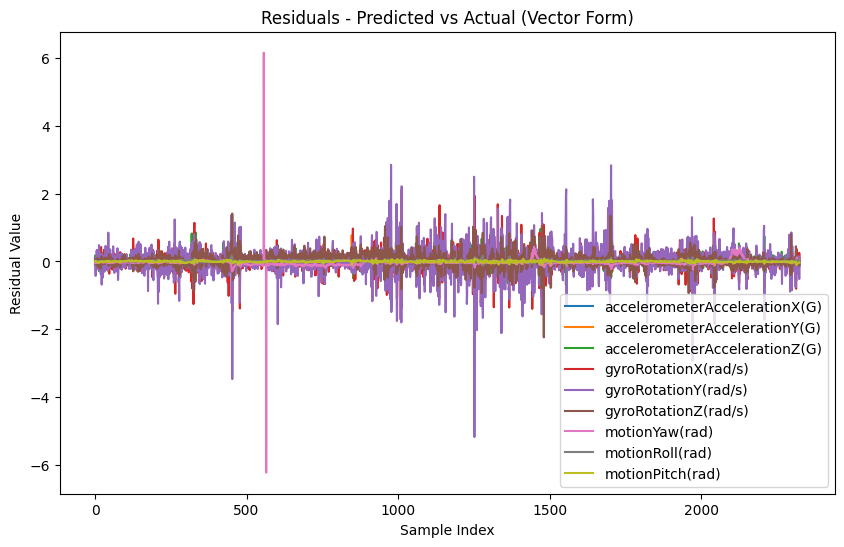

Anomaly Percentage for accelerometerAccelerationX(G): 0.04%
Anomaly Percentage for accelerometerAccelerationY(G): 0.39%
Anomaly Percentage for accelerometerAccelerationZ(G): 2.02%
Anomaly Percentage for gyroRotationX(rad/s): 7.78%
Anomaly Percentage for gyroRotationY(rad/s): 15.91%
Anomaly Percentage for gyroRotationZ(rad/s): 3.48%
Anomaly Percentage for motionYaw(rad): 0.13%
Anomaly Percentage for motionRoll(rad): 0.00%
Anomaly Percentage for motionPitch(rad): 0.00%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you already have X2 and y2 defined
train_predictions = model1.predict(X_test)
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

all_residuals = []  # List to store residuals for each output

# Dictionary to store anomaly percentages for each output
anomaly_percentages = {}

for i in range(y_test.shape[1]):
    # Select the column corresponding to the current output from test_predictions
    predicted_column = test_predictions[:, i]

    # Select the column corresponding to the current output from y2
    actual_column = y_test[:, i]

    # Calculate residuals in vector form
    residuals = predicted_column - actual_column
    all_residuals.append(residuals)

    # Calculate the percentage of anomalies based on a threshold
    threshold = 0.5  # Adjust the threshold based on your requirements
    anomalies = (np.abs(residuals) > threshold).astype(int)
    anomaly_percentage = np.mean(anomalies) * 100
    anomaly_percentages[output_labels[i]] = anomaly_percentage

    # ... (rest of the plotting and visualization code)

# Convert the list of residuals into a NumPy array for further analysis if needed
all_residuals = np.array(all_residuals)

# Visualize the residuals in vector form
plt.figure(figsize=(10, 6))
plt.plot(all_residuals.T, label=output_labels)
plt.xlabel('Sample Index')
plt.ylabel('Residual Value')
plt.title('Residuals - Predicted vs Actual (Vector Form)')
plt.legend()
plt.show()

# Print anomaly percentages
for output_label, percentage in anomaly_percentages.items():
    print(f"Anomaly Percentage for {output_label}: {percentage:.2f}%")


In [ ]:
# Evaluate the model
mae_test_per_output = [mean_absolute_error(y_test[:, i], test_predictions[:, i]) for i in range(test_predictions.shape[1])]
overall_mae_test = np.mean(mae_test_per_output)

mae_val_per_output = [mean_absolute_error(y_val[:, i], val_predictions[:, i]) for i in range(val_predictions.shape[1])]
overall_mae_val = np.mean(mae_val_per_output)


print(f'Overall Mean Absolute Error of test: {overall_mae_test}')
print(f'Overall Mean Absolute Error of val: {overall_mae_val}')

Overall Mean Absolute Error of test: 0.11240202921619735
Overall Mean Absolute Error of val: 0.08609099786860633


In [ ]:
print("y_train shape:", y_train.shape)
print("train_predictions shape:", train_predictions.shape)


y_train shape: (83736,)
train_predictions shape: (2326, 9)


In [ ]:
y_train_reshape = y_train.reshape(-1, 1)  # Reshape to have one column
mae_train_per_output = [np.abs(y_train_reshape - train_predictions[:, i]).mean() for i in range(train_predictions.shape[1])]
overall_mae_train = np.mean(mae_train_per_output)
print(f'Overall Mean Absolute Error of train: {overall_mae_train}')


Overall Mean Absolute Error of train: 0.6242270498065565


In [ ]:
# Assuming test_predictions is a 1D array and you want to reshape it
num_columns = y_train.shape[]
train_predictions = train_predictions.reshape(-1, num_columns)

# Evaluate the model
mae_train_per_output = [mean_absolute_error(y_test[:, i], train_predictions[:, i]) for i in range(num_columns)]
overall_mae_train = np.mean(mae_train_per_output)

print(f'Overall Mean Absolute Error of test: {overall_mae_train}')

SyntaxError: invalid syntax (<ipython-input-34-9fd7ec9cdbab>, line 2)

In [ ]:
# Assuming you have already defined train_predictions, y_train, val_predictions, and y_val
# train_predictions, y_train, val_predictions, y_val = ...

# Reshape y_train and y_val to match the number of output dimensions
y_train_reshaped = y_train.reshape(-1, num_outputs)
y_val_reshaped = y_val.reshape(-1, num_outputs)
y_test_reshaped = y_test.reshape(-1, num_outputs)

# Ensure that y_train_reshaped and train_predictions have the same number of samples
min_samples = min(y_train_reshaped.shape[0], train_predictions.shape[0])
y_train_reshaped = y_train_reshaped[:min_samples, :]
train_predictions = train_predictions[:min_samples, :]

# Ensure that y_val_reshaped and val_predictions have the same number of samples
min_samples_val = min(y_val_reshaped.shape[0], val_predictions.shape[0])
y_val_reshaped = y_val_reshaped[:min_samples_val, :]
val_predictions = val_predictions[:min_samples_val, :]

# Ensure that y_test_reshaped and test_predictions have the same number of samples
min_samples_test = min(y_test_reshaped.shape[0], test_predictions.shape[0])
y_test_reshaped = y_test_reshaped[:min_samples_test, :]
test_predictions = test_predictions[:min_samples_test, :]


# Calculate mean absolute error for each output dimension
mae_train_per_output = [mean_absolute_error(y_train_reshaped[:, i], train_predictions[:, i]) for i in range(train_predictions.shape[1])]
mae_val_per_output = [mean_absolute_error(y_val_reshaped[:, i], val_predictions[:, i]) for i in range(val_predictions.shape[1])]
mae_test_per_output = [mean_absolute_error(y_test_reshaped[:, i], test_predictions[:, i]) for i in range(test_predictions.shape[1])]

# Calculate overall mean absolute error
overall_mae_train = np.mean(mae_train_per_output)
overall_mae_val = np.mean(mae_val_per_output)
overall_mae_test = np.mean(mae_test_per_output)

print(f'Overall Mean Absolute Error of train: {overall_mae_train}')
print(f'Overall Mean Absolute Error of val: {overall_mae_val}')
print(f'Overall Mean Absolute Error of test: {overall_mae_test}')



Overall Mean Absolute Error of train: 0.3039396900632295
Overall Mean Absolute Error of val: 0.08609099786860633
Overall Mean Absolute Error of test: 0.11240202921619735


# TESTING



In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/2_wheeler_related/finalday32.csv', parse_dates=['loggingTime(txt)'])
df1['loggingTime(txt)'] = df1['loggingTime(txt)'].dt.tz_localize(None)
df1.set_index('loggingTime(txt)', inplace=True)
print(df.index[:5])

DatetimeIndex(['2023-10-12 00:07:51.978000', '2023-10-12 00:07:52.077000',
               '2023-10-12 00:07:52.177000', '2023-10-12 00:07:52.281000',
               '2023-10-12 00:07:52.377000'],
              dtype='datetime64[ns]', name='loggingTime(txt)', freq=None)


In [ ]:
data = df[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)','gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)','motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']]

In [ ]:
WINDOW_SIZE = 9
X2, y2 = df_to_X_y(data, WINDOW_SIZE)

364/364 [==============================] - 33s 92ms/step


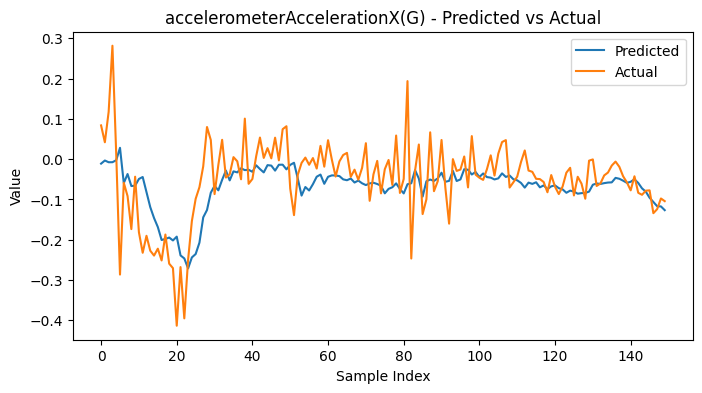

RMSE for accelerometerAccelerationX(G): 0.058377618142519815


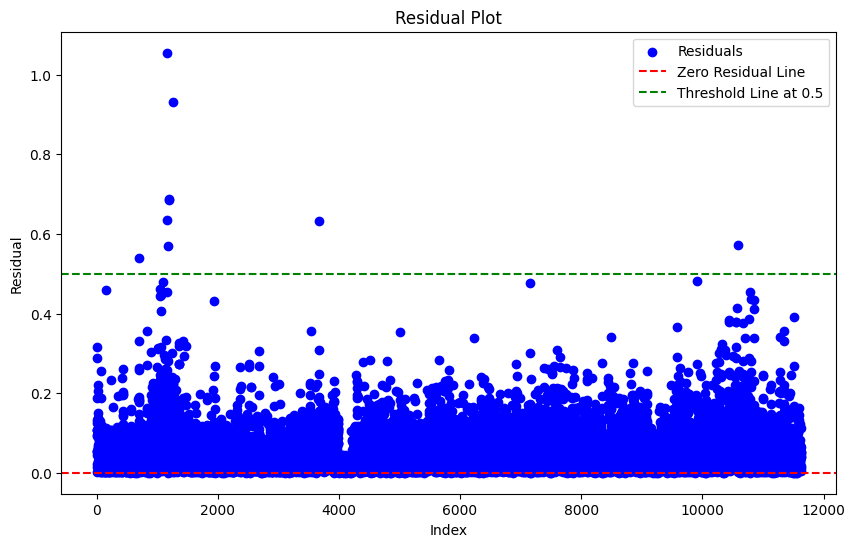

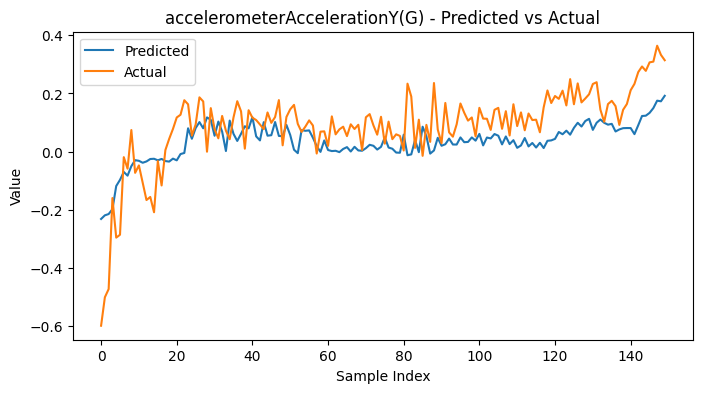

RMSE for accelerometerAccelerationY(G): 0.0742019937581885


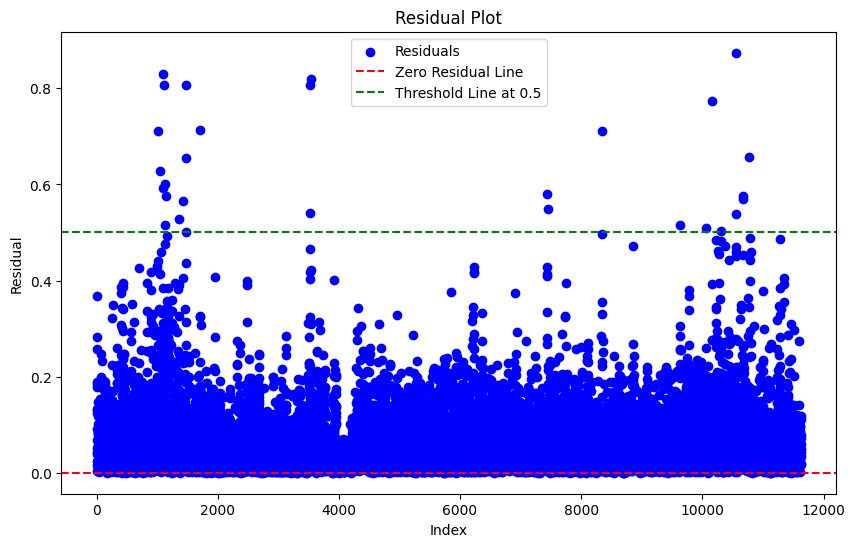

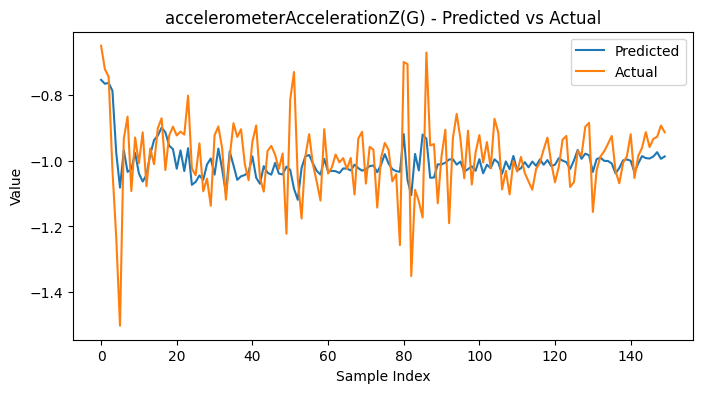

RMSE for accelerometerAccelerationZ(G): 0.10750513018868889


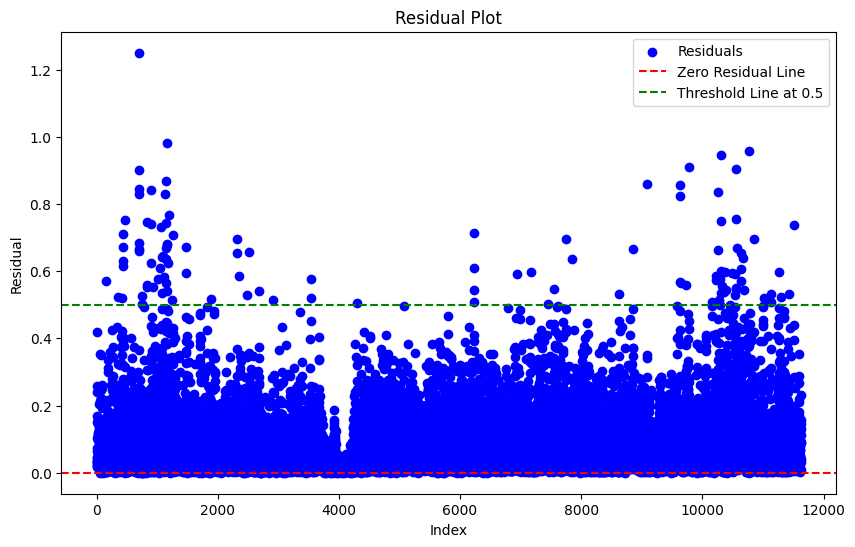

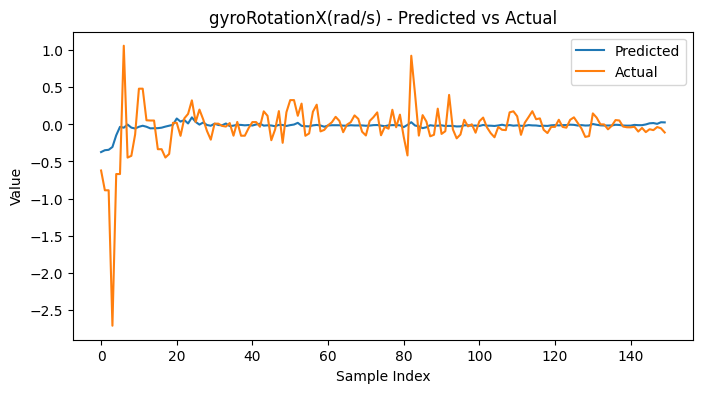

RMSE for gyroRotationX(rad/s): 0.17397295273407123


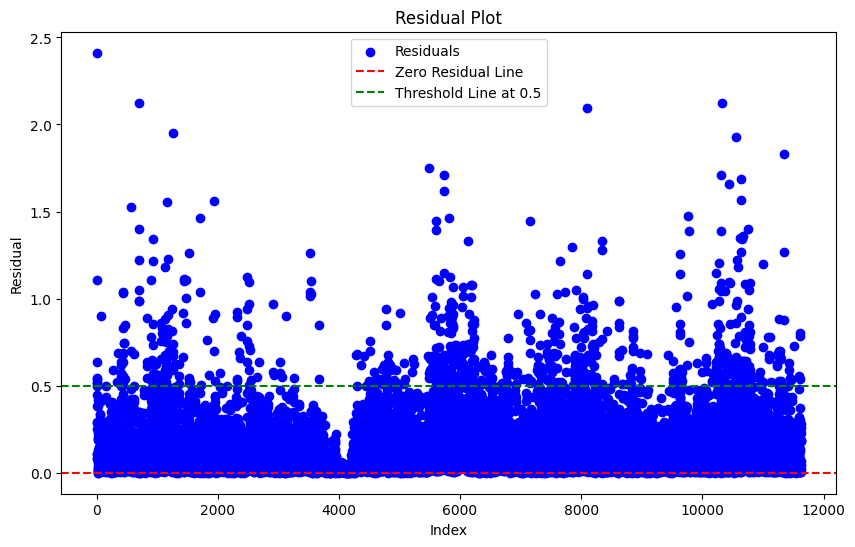

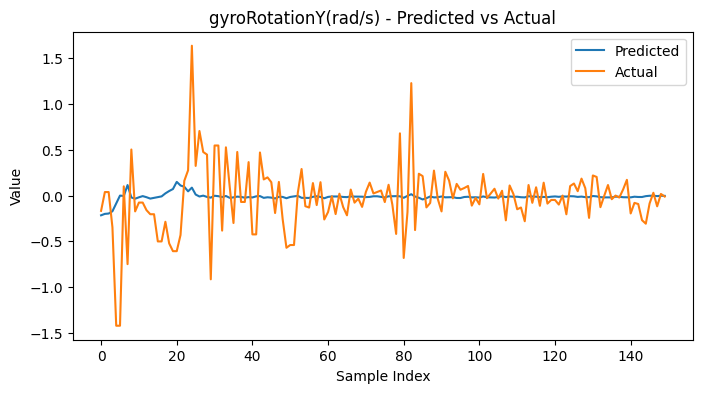

RMSE for gyroRotationY(rad/s): 0.2534354791217329


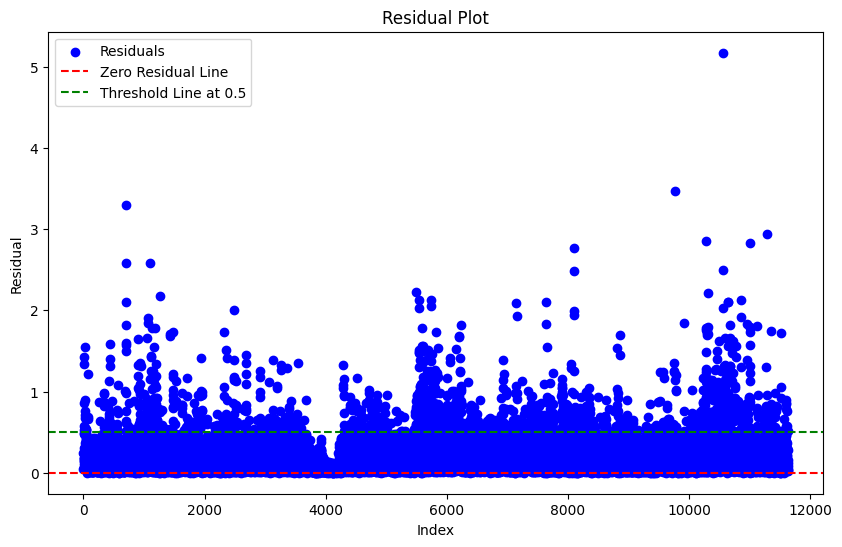

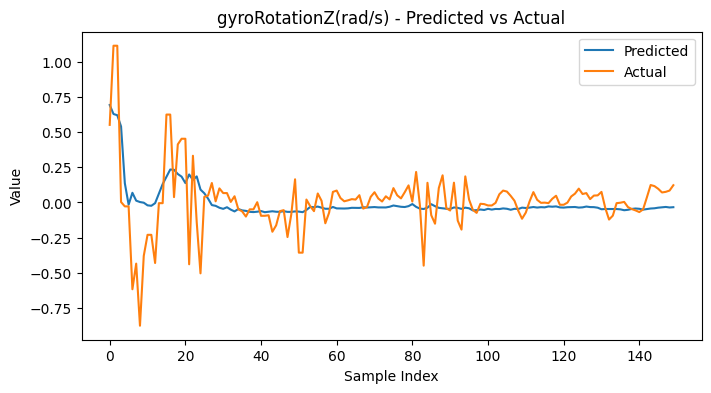

RMSE for gyroRotationZ(rad/s): 0.10895766534124855


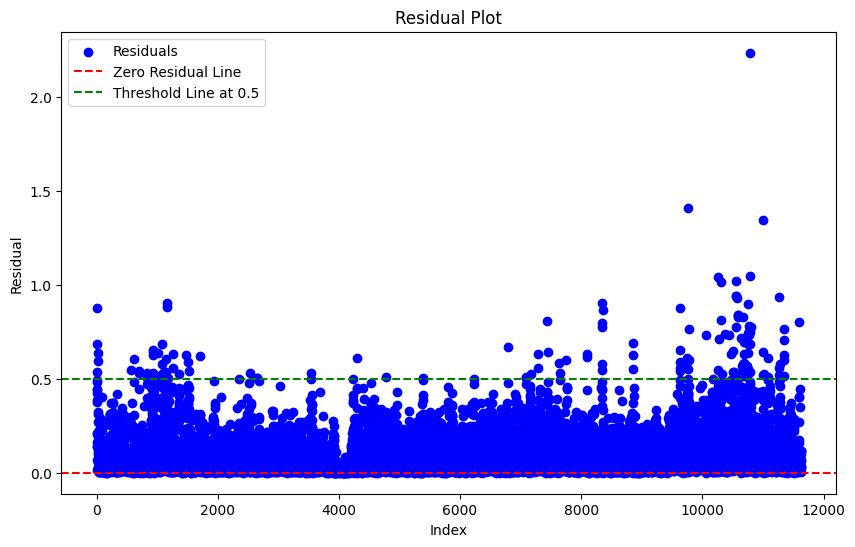

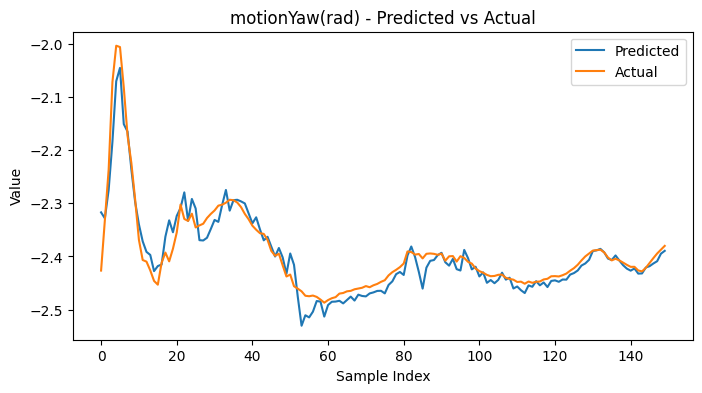

RMSE for motionYaw(rad): 0.02687070695751817


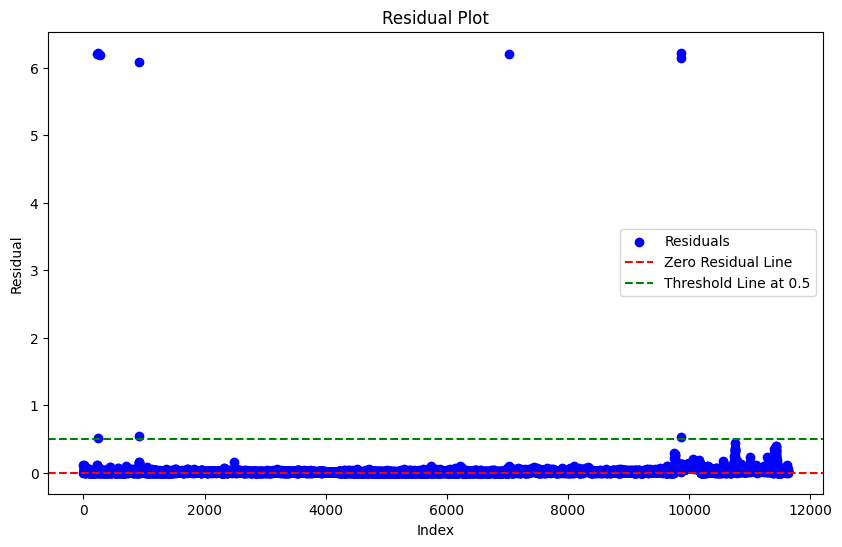

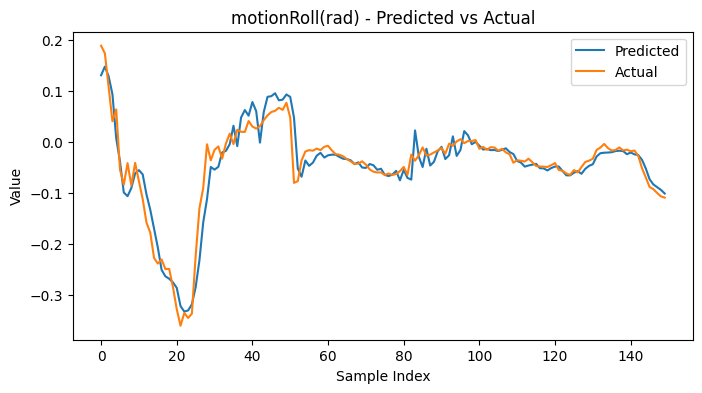

RMSE for motionRoll(rad): 0.012556975624209873


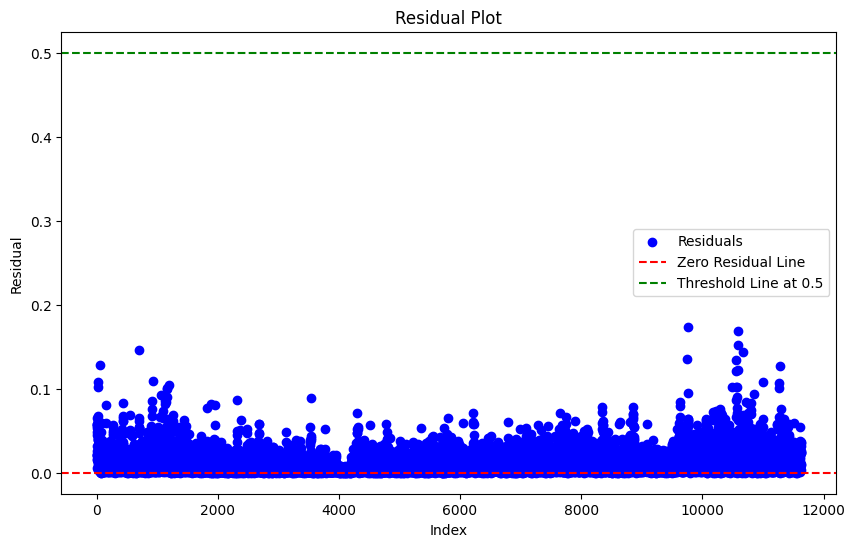

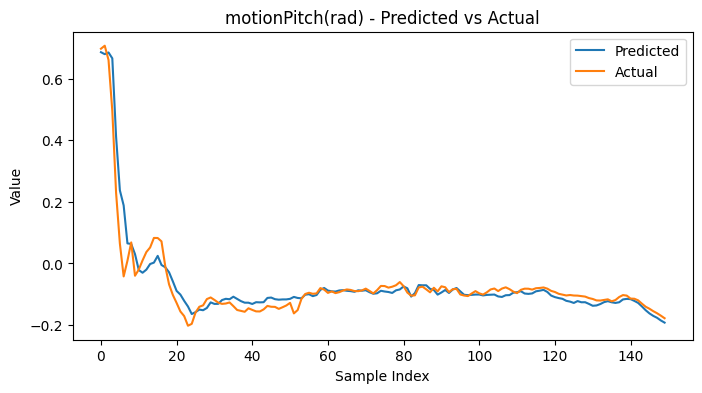

RMSE for motionPitch(rad): 0.014046382996774237


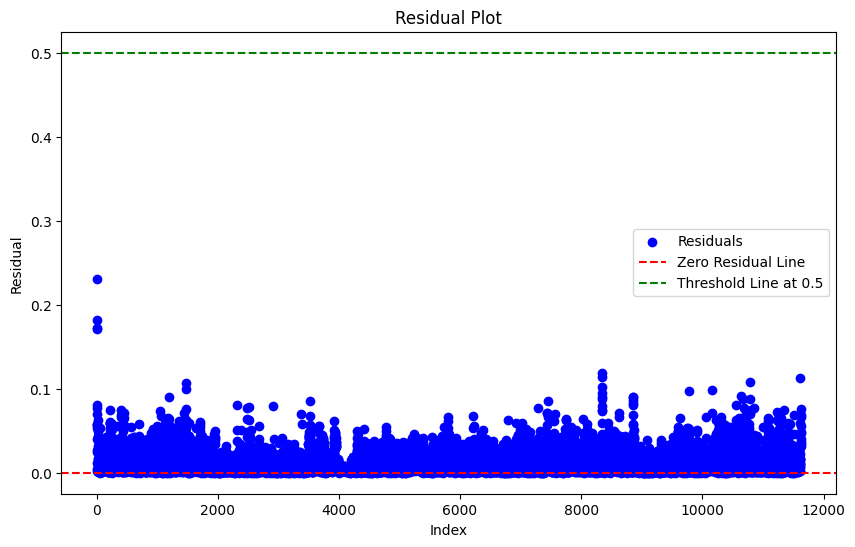

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you already have X2 and y2 defined
test_predictions = model1.predict(X2)
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

for i in range(y2.shape[1]):
    # Select the column corresponding to the current output from test_predictions
    predicted_column = test_predictions[:, i]

    # Select the column corresponding to the current output from y2
    actual_column = y2[:, i]

    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': predicted_column.flatten(), 'Actual': actual_column.flatten()})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'][:150], label='Predicted')
    plt.plot(output_data['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} - Predicted vs Actual')
    plt.legend()
    plt.show()

    # Calculate and print RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['Squared Residual'] = np.square(output_data['Residual'])
    output_data['RMSE'] = np.sqrt(output_data['Squared Residual'])
    rmse = output_data['RMSE'].mean()
    print(f"RMSE for {output_labels[i]}: {rmse}")

    # Residual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(output_data.index, output_data['RMSE'], color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')  # Threshold line at 0.5
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title( 'Residual Plot')
    plt.legend()
    plt.show()


364/364 [==============================] - 34s 94ms/step


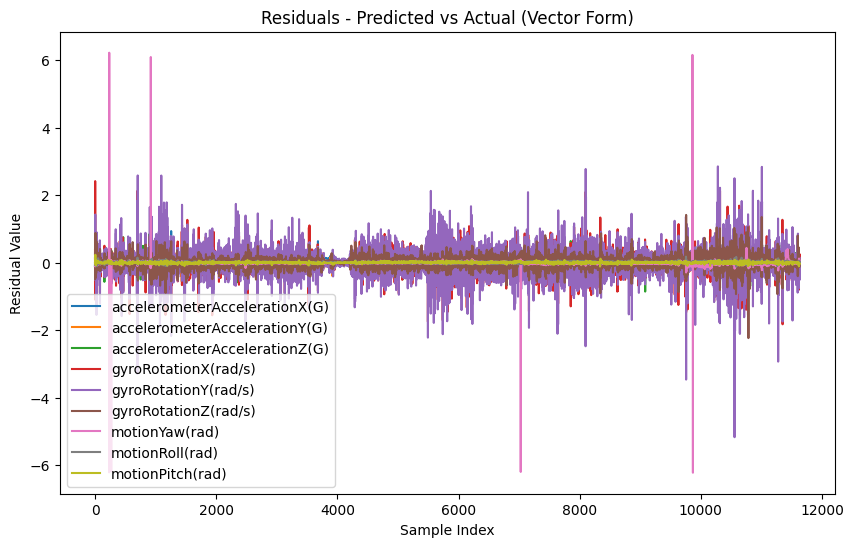

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you already have X2 and y2 defined
test_predictions = model1.predict(X2)
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

all_residuals = []  # List to store residuals for each output

for i in range(y2.shape[1]):
    # Select the column corresponding to the current output from test_predictions
    predicted_column = test_predictions[:, i]

    # Select the column corresponding to the current output from y2
    actual_column = y2[:, i]

    # Calculate residuals in vector form
    residuals = predicted_column - actual_column
    all_residuals.append(residuals)

    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': predicted_column.flatten(), 'Actual': actual_column.flatten(), 'Residual': residuals.flatten()})

    # Plot predicted and actual values
    # ... (rest of the plotting code)

    # Calculate and print RMSE
    # ... (rest of the RMSE calculation code)

    # Residual plot
    # ... (rest of the residual plot code)

# Convert the list of residuals into a NumPy array for further analysis if needed
all_residuals = np.array(all_residuals)

# Visualize the residuals in vector form
plt.figure(figsize=(10, 6))
plt.plot(all_residuals.T, label=output_labels)
plt.xlabel('Sample Index')
plt.ylabel('Residual Value')
plt.title('Residuals - Predicted vs Actual (Vector Form)')
plt.legend()
plt.show()


In [ ]:
# Assuming you have test_predictions and y2 defined

# Calculate residuals between predicted and actual outputs
all_residuals = test_predictions - y2

# Define a threshold for anomaly detection
threshold = 0.5  # Change this value based on your analysis

# Identify anomalies based on the threshold
anomalies = np.abs(all_residuals) > threshold

# Calculate the percentage of anomalies detected
percentage_anomalies = np.mean(anomalies) * 100

print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

Percentage of anomalies detected: 2.34%


In [ ]:
import numpy as np

all_residual_values = np.zeros((y2.shape[0],))

for i in range(y2.shape[0]):
    vector_magnitude_test_predictions = np.linalg.norm(test_predictions[i, :])
    vector_magnitude_y_test = np.linalg.norm(y2[i, :])

    all_residual_values[i] = vector_magnitude_test_predictions - vector_magnitude_y_test

print(all_residual_values)

[-0.14104001 -0.29690322 -0.26271367 ... -0.099506   -0.10465622
  0.11025033]


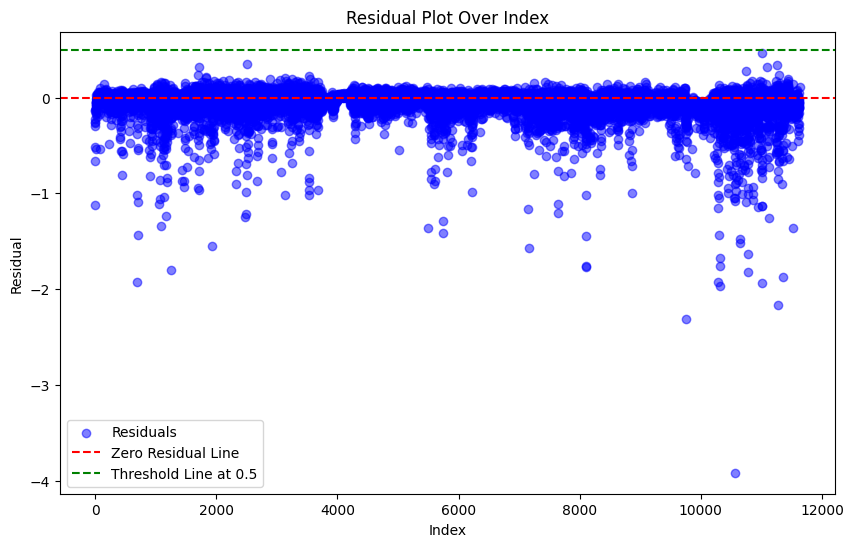

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot of residuals against index
plt.scatter(np.arange(len(all_residual_values)), all_residual_values, color='blue', label='Residuals', alpha=0.5)

# Horizontal lines
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot Over Index')

# Legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
absolute_residual_values = np.abs(all_residual_values)

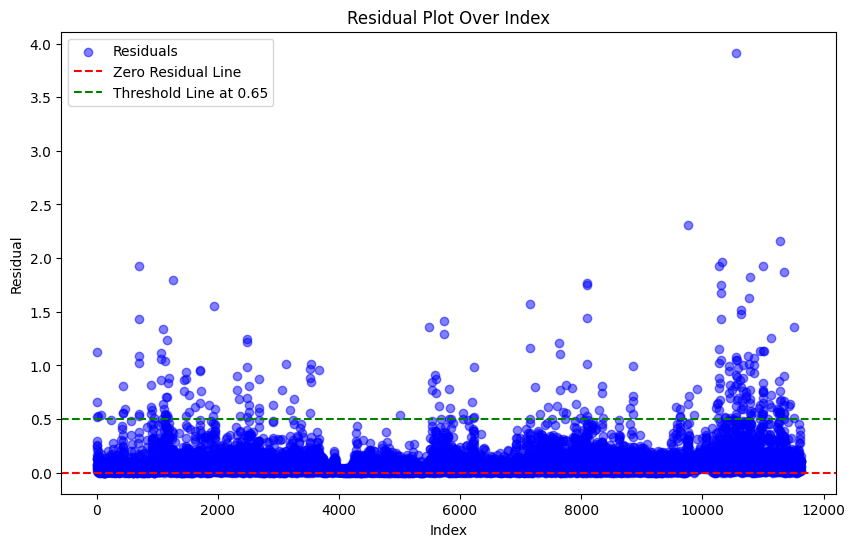

In [ ]:
#Absolute of
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot of residuals against index
plt.scatter(np.arange(len(absolute_residual_values)), absolute_residual_values, color='blue', label='Residuals', alpha=0.5)

# Horizontal lines
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.65')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot Over Index')

# Legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Assuming 'threshold' is the chosen threshold for anomalies
threshold = 0.5
anomaly_indicator = (absolute_residual_values > threshold).astype(int)
print(anomaly_indicator)

[0 0 0 ... 0 0 0]


In [ ]:
df1['label(N)'].shape

(8215,)

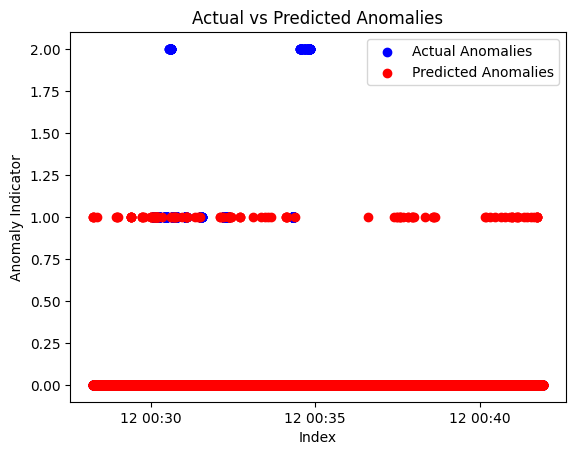

In [ ]:
import matplotlib.pyplot as plt

# Assuming df1 is your DataFrame containing the label column and anomaly_indicator

# Check the lengths of df1.index and anomaly_indicator
if len(df1.index) != len(anomaly_indicator):
    # Handle the mismatch in lengths, such as by trimming or padding one of the arrays
    min_length = min(len(df1.index), len(anomaly_indicator))
    df1.index = df1.index[:min_length]
    anomaly_indicator = anomaly_indicator[:min_length]

# Plotting the actual anomalies
plt.scatter(df1.index, df1['label(N)'], color='blue', label='Actual Anomalies')

# Plotting the predicted anomalies
plt.scatter(df1.index, anomaly_indicator, color='red', marker='o', label='Predicted Anomalies')  # Use 'o' as marker instead of 'blue'

# Setting labels and title
plt.xlabel('Index')
plt.ylabel('Anomaly Indicator')
plt.title('Actual vs Predicted Anomalies')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Assuming df is your DataFrame
rows_to_remove = 8
random_rows_indices = np.random.choice(df1.index, rows_to_remove, replace=False)

# Remove the randomly selected rows in-place
df1.drop(random_rows_indices, inplace=True)


In [ ]:
from sklearn.metrics import classification_report

# Assuming 'true_labels' is the true label column from your dataset
classification_report(df1['label(N)'], anomaly_indicator)


ValueError: Found input variables with inconsistent numbers of samples: [8207, 8215]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming 'threshold' is the chosen threshold for anomalies
threshold = 0.4
anomaly_indicator = (absolute_residual_values > threshold).astype(int)
print(anomaly_indicator.shape)

# Assuming 'true_labels' is the true label column from your dataset
true_labels = df1['label(N)']

# Align the lengths of true_labels and anomaly_indicator
min_length = min(len(true_labels), len(anomaly_indicator))
true_labels = true_labels[:min_length]
anomaly_indicator = anomaly_indicator[:min_length]

# Generate classification report
report = classification_report(true_labels, anomaly_indicator)

# Split the classification report into lines
lines = report.split('\n')

# Extract class names and metrics
class_names = lines[0].split()
metrics = [line.split() for line in lines[2:-5]]

# Create a DataFrame
report_df = pd.DataFrame(metrics, columns=['Class'] + class_names)

# Print the formatted classification report
print(report_df)


(11630,)
  Class precision recall f1-score support
0     0      0.93   0.98     0.95    7622
1     1      0.18   0.07     0.10     468
2     2      0.00   0.00     0.00     117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_anomalies = df1[df1['label(N)'].isin([1, 2])].shape[0]
print("Total number of anomalies:", total_anomalies)
num_detected_anomalies = anomaly_indicator.sum()
print("Number of anomalies detected:", num_detected_anomalies)


Total number of anomalies: 585
Number of anomalies detected: 191


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train_results.index, train_results['Residual'], color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.legend()
plt.show()

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
test_data_pred['Residual'] = test_data_pred['Predicted'] - test_data_pred['Actual']


NameError: ignored

In [ ]:
print(train_results['Actuals'][3779:3783])
print(train_results['Train Predictions'][3779:3783])
train_results['Residual'] = train_results['Train Predictions'] - train_results['Actuals']
print(train_results['Residual'][3779:3783])

3779   -0.139472
3780   -0.021591
3781    0.186996
3782   -1.264954
Name: Actuals, dtype: float64
3779   -0.137279
3780   -0.116181
3781    0.066737
3782   -1.125839
Name: Train Predictions, dtype: float32
3779    0.002193
3780   -0.094590
3781   -0.120259
3782    0.139114
Name: Residual, dtype: float64


In [ ]:
filtered_results = train_results[(train_results['Residual'] > 0.5) | (train_results['Residual'] < -0.5)]
print(filtered_results)

       Train Predictions   Actuals  Residual
1              -0.085046 -0.598770  0.513724
14              0.130399  1.112274 -0.981875
23              0.092661  1.112274 -1.019613
30             -0.648948 -2.716944  2.067996
40             -0.378634 -1.422392  1.043759
...                  ...       ...       ...
81731          -0.849773 -0.070404 -0.779369
81732           0.397102 -0.173717  0.570819
81742          -0.208935  0.582986 -0.791921
83668          -0.119473  0.406742 -0.526215
83695          -0.052287  0.503633 -0.555919

[880 rows x 3 columns]


Epoch 1/10
255/255 [==============================] - 36s 32ms/step - loss: 0.4259 - root_mean_squared_error: 0.6526 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2873
Epoch 2/10
255/255 [==============================] - 8s 33ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727 - val_loss: 0.1074 - val_root_mean_squared_error: 0.3278
Epoch 3/10
255/255 [==============================] - 6s 23ms/step - loss: 0.0993 - root_mean_squared_error: 0.3152 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 4/10
255/255 [==============================] - 8s 33ms/step - loss: 0.0895 - root_mean_squared_error: 0.2991 - val_loss: 0.0490 - val_root_mean_squared_error: 0.2213
Epoch 5/10
255/255 [==============================] - 6s 22ms/step - loss: 0.0850 - root_mean_squared_error: 0.2915 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2401
Epoch 6/10
255/255 [==============================] - 7s 28ms/step - loss: 0.0865 - root_mean_squared_error: 0.2940 - val_loss: 0.0487

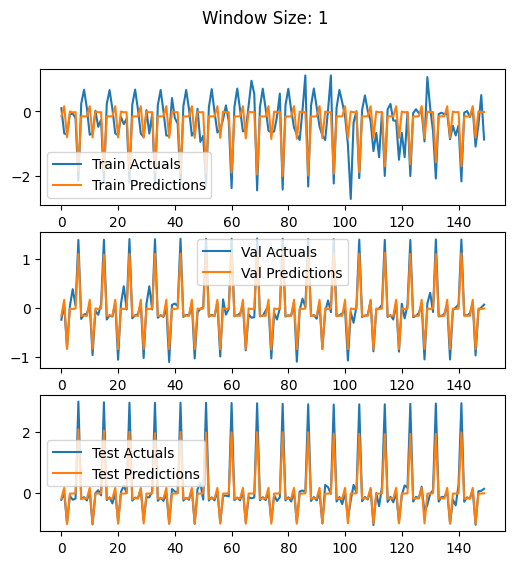

Epoch 1/10
255/255 [==============================] - 38s 46ms/step - loss: 0.2573 - root_mean_squared_error: 0.5072 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2395
Epoch 2/10
255/255 [==============================] - 11s 42ms/step - loss: 0.1026 - root_mean_squared_error: 0.3204 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2132
Epoch 3/10
255/255 [==============================] - 12s 48ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2509
Epoch 4/10
255/255 [==============================] - 10s 39ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2343
Epoch 5/10
255/255 [==============================] - 11s 42ms/step - loss: 0.0693 - root_mean_squared_error: 0.2632 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 6/10
255/255 [==============================] - 13s 49ms/step - loss: 0.0675 - root_mean_squared_error: 0.2599 - val_loss: 0

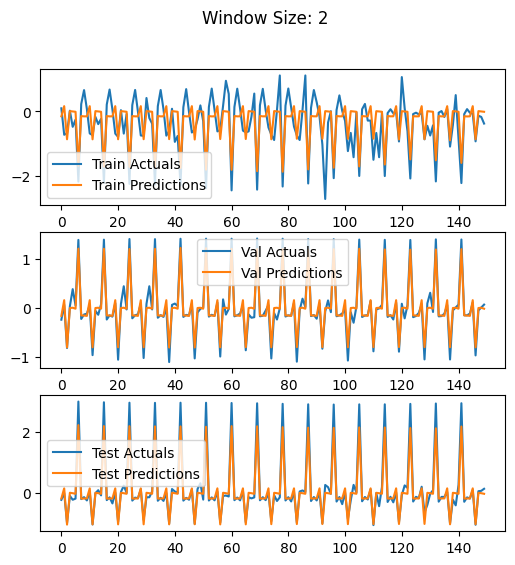

Epoch 1/10
255/255 [==============================] - 44s 73ms/step - loss: 0.3047 - root_mean_squared_error: 0.5520 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 2/10
255/255 [==============================] - 16s 61ms/step - loss: 0.1231 - root_mean_squared_error: 0.3509 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2592
Epoch 3/10
255/255 [==============================] - 15s 61ms/step - loss: 0.0995 - root_mean_squared_error: 0.3155 - val_loss: 0.0559 - val_root_mean_squared_error: 0.2364
Epoch 4/10
255/255 [==============================] - 15s 60ms/step - loss: 0.0820 - root_mean_squared_error: 0.2864 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2139
Epoch 5/10
255/255 [==============================] - 15s 61ms/step - loss: 0.0780 - root_mean_squared_error: 0.2794 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2409
Epoch 6/10
255/255 [==============================] - 15s 60ms/step - loss: 0.0773 - root_mean_squared_error: 0.2780 - val_loss: 0

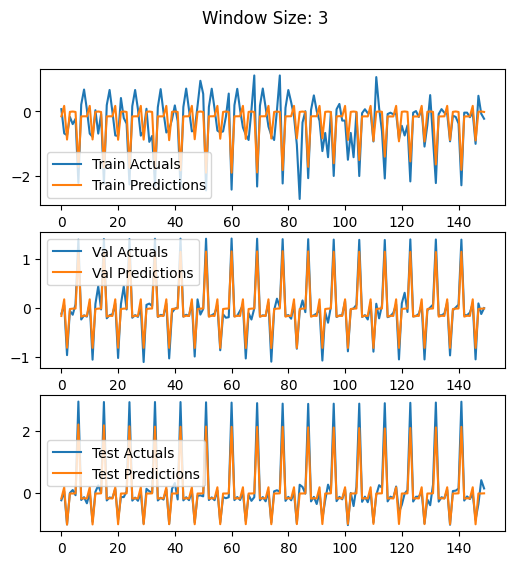

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
for WINDOW_SIZE in range(1, 9):
    X1, y1 = df_to_X_y(data, WINDOW_SIZE)

    total_samples = len(X1)
    train_samples = int(0.7 * total_samples)
    val_samples = int(0.15 * total_samples)
    test_samples = total_samples - train_samples - val_samples

    # Split the data
    X_train, y_train = X1[:train_samples], y1[:train_samples]
    X_val, y_val = X1[train_samples:train_samples + val_samples], y1[train_samples:train_samples + val_samples]
    X_test, y_test = X1[train_samples + val_samples:], y1[train_samples + val_samples:]

    model1 = Sequential()
    model1.add(InputLayer((WINDOW_SIZE, 9)))
    model1.add(Bidirectional(GRU(128, return_sequences=True, activation='relu', dropout=0.2, recurrent_dropout=0.2)))
    model1.add(Bidirectional(GRU(64, return_sequences=True, activation='relu', dropout=0.2, recurrent_dropout=0.2)))
    model1.add(Bidirectional(GRU(32, return_sequences=True, activation='relu', dropout=0.2, recurrent_dropout=0.2)))
    model1.add(Bidirectional(GRU(16, activation='relu', dropout=0.2, recurrent_dropout=0.2)))


# Dense layers
    model1.add(Dense(8, activation='relu'))
    model1.add(Dropout(0.2))
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-3), metrics=[RootMeanSquaredError()])
# Output layer
    model1.add(Dense (9, activation='LeakyReLU'))
    model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

    train_predictions = model1.predict(X_train).flatten()
# Assuming train_predictions and y_train are 1D arrays
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions.flatten(), 'Actuals': y_train.flatten()})

    val_predictions = model1.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions': val_predictions.flatten(), 'Actuals': y_val.flatten()})

    test_predictions = model1.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions': test_predictions.flatten(), 'Actuals': y_test.flatten()})

    plt.figure(figsize=(6, 6))
    plt.subplot(3, 1, 1)
    plt.plot(train_results['Actuals'][:150], label='Train Actuals')
    plt.plot(train_results['Train Predictions'][:150], label='Train Predictions')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(val_results['Actuals'][:150], label='Val Actuals')
    plt.plot(val_results['Val Predictions'][:150], label='Val Predictions')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(test_results['Actuals'][:150], label='Test Actuals')
    plt.plot(test_results['Test Predictions'][:150], label='Test Predictions')
    plt.legend()

    plt.suptitle(f'Window Size: {WINDOW_SIZE}')
    plt.show()

255/255 [==============================] - 1s 5ms/step


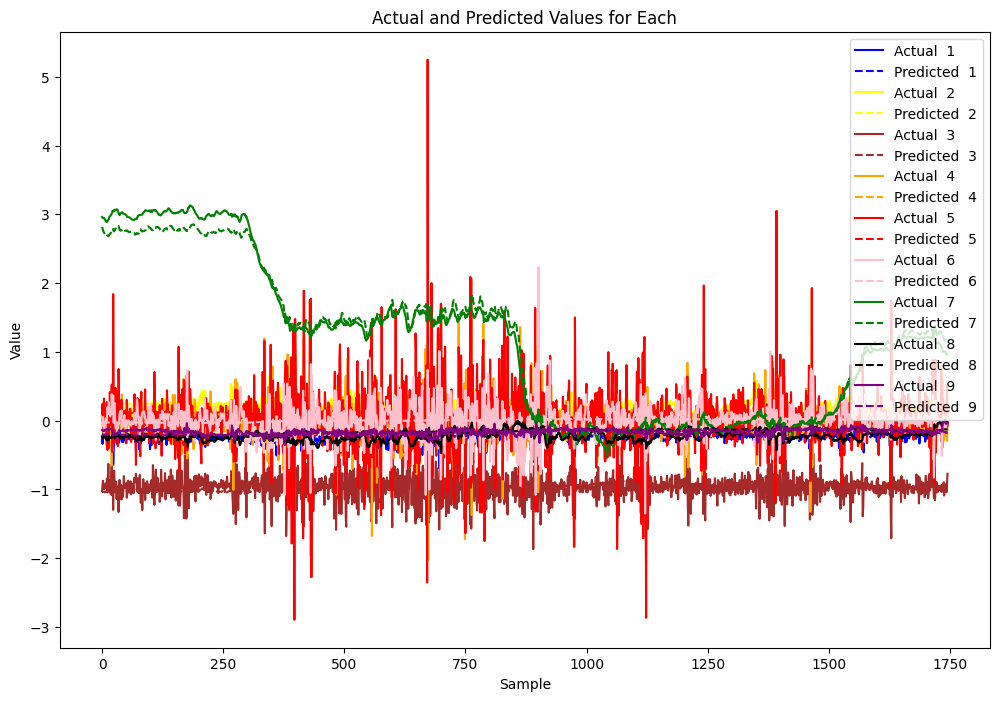

In [ ]:
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)
train_predictions = model.predict(X_train)

# For each output
output_colors = ['blue', 'yellow', 'brown', 'orange', 'red', 'pink', 'green', 'black', 'purple']

# Plotting
plt.figure(figsize=(12, 8))

# Iterate over each output
for i in range(9):
    plt.plot(y_test[:, i], label=f'Actual  {i+1}', color=output_colors[i], linestyle='-')
    plt.plot(test_predictions[:, i], label=f'Predicted  {i+1}', color=output_colors[i], linestyle='--')

plt.legend()
plt.title('Actual and Predicted Values for Each')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()


In [ ]:
# For test
# Calculate Mean Absolute Error (MAE)
mae_per_output = mean_absolute_error(y_test, test_predictions, multioutput='raw_values')
overall_mae = np.mean(mae_per_output)
for i, mae in enumerate(mae_per_output):
    print(f'MAE for Output {i+1}: {mae}')
print(f'Overall MAE: {overall_mae}')

# Calculate Mean Squared Error (MSE)
mse_per_output = mean_squared_error(y_test, test_predictions, multioutput='raw_values')
overall_mse = np.mean(mse_per_output)
for i, mse in enumerate(mse_per_output):
    print(f'MSE for Output {i+1}: {mae}')
print(f'Overall MSE: {overall_mse}')

# Calculate Root Mean Squared Error (RMSE) for each output
rmse_per_output = np.sqrt(mse_per_output)
overall_rmse = np.mean(rmse_per_output)
for i, rmse in enumerate(rmse_per_output):
    print(f'RMSE for Output {i+1}: {rmse}')
print(f'Overall RMSE: {rmse}')

MAE for Output 1: 0.08636506942163764
MAE for Output 2: 0.09996383009480583
MAE for Output 3: 0.14075167444699954
MAE for Output 4: 0.22854557476908532
MAE for Output 5: 0.3281208232888051
MAE for Output 6: 0.16634280282007347
MAE for Output 7: 0.09132495724500675
MAE for Output 8: 0.07974603240263427
MAE for Output 9: 0.0349487742574143
Overall MAE: 0.1395677265273847
MSE for Output 1: 0.0349487742574143
MSE for Output 2: 0.0349487742574143
MSE for Output 3: 0.0349487742574143
MSE for Output 4: 0.0349487742574143
MSE for Output 5: 0.0349487742574143
MSE for Output 6: 0.0349487742574143
MSE for Output 7: 0.0349487742574143
MSE for Output 8: 0.0349487742574143
MSE for Output 9: 0.0349487742574143
Overall MSE: 0.057010483795786916
RMSE for Output 1: 0.11333179862709529
RMSE for Output 2: 0.13621287926175837
RMSE for Output 3: 0.19644848541640944
RMSE for Output 4: 0.33458826425580857
RMSE for Output 5: 0.49686611599503655
RMSE for Output 6: 0.24015645662961768
RMSE for Output 7: 0.124802